In [8]:
import json
from pprint import pprint
from termcolor import colored
from colored import fg, bg, attr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# if using a Jupyter notebook, includue:
%matplotlib inline
data_file = "predictor_result_10000_exmaples.jsonl"
id2name = "../data/id2name.json"

color = bg('yellow_1') + fg('black')
reset = attr('reset')
blue = "blue"
green = "green"

print()

with open(id2name, 'r') as fp:
    id2name = json.load(fp)


In [9]:
def change_word_by_entity(entity_str, this_sentence,i,color):
        if list(map(lambda x: x.lower(), this_sentence[i:i + len(entity_str.split(" "))])) == entity_str.split():
            this_sentence = this_sentence[:i] + [colored(w, color, attrs=['bold']) for w in entity_str.split()] + \
                            this_sentence[i + len(entity_str.split(" ")):]
        return this_sentence


In [10]:
preffix = ""
def _show_sentence(head,tail,this_sentence,relation,correct_relation = None, is_prediction = False,prob : str = "",score: str = "",set_gold= None):     
    print(preffix + "head:", colored(head, 'blue', attrs=['bold']), "  ,  ", "tail", colored(tail, 'green', attrs=['bold']))          
    this_sentence = this_sentence.split()
    for i, word in enumerate(this_sentence):
            if word.lower() == head.split()[0]:
                this_sentence = change_word_by_entity(head, this_sentence,i,blue)
            if word.lower() == tail.split()[0]:
                this_sentence = change_word_by_entity(tail, this_sentence,i,green)
    color = 'yellow' if correct_relation is None or relation == correct_relation else 'grey'
    if is_prediction: color = "red"
    if set_gold and set_gold == "NOTA":
        print(colored("NOTA", color,attrs=['bold'])+ " " + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence) +" " + colored(prob, "magenta",attrs=['bold'])+"; "+ 
            colored(score, "magenta",attrs=['bold']))
    elif len(prob) > 0:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence) +" " + colored(prob, "magenta",attrs=['bold'])+"; "+ 
              colored(score, "magenta",attrs=['bold']))
    else:
        print(preffix + colored(relation, color,attrs=['bold']) + "\t", " ".join(this_sentence))

In [11]:
def show_set(data):
    scores = data['scores']
    set_pred = data['sentence_' + data["prediction"] +'_relation'] if int(data["prediction"]) + 1 < len(scores) else "NOTA"
    set_gold = data['correct_relation'] if int(data["gold"]) + 1 < len(scores) else "NOTA"
    correct_relation = data['correct_relation']
    prediction = data["prediction"]
    query = data['query']
    head = data['query_head']
    tail = data['query_tail']
    probability = data['probability'].replace("'","")[1:-1].split(",")
    scores = data['scores']
    _show_sentence(head,tail,query,correct_relation,set_gold=set_gold)
    print()

    for k in range(5):
        this_sentence = data["sentence_" +str(k)]
        head = data['sentence_'+str(k)+'_head']
        tail = data['sentence_'+str(k)+'_tail']
        relation = data['sentence_'+str(k)+'_relation']
        _show_sentence(head,tail,this_sentence,relation,correct_relation,  k == int(prediction),probability[k],
                       "{:.2f}".format(scores[k]))
    color = 'yellow' if set_gold is None or set_gold == "NOTA" else 'grey'
    if set_pred != set_gold: color = "red"
    print(colored("NOTA", color,attrs=['bold']) + " " + colored(probability[-1], "magenta",attrs=['bold'])+"; "+ 
              colored(scores[-1], "magenta",attrs=['bold']))

    print()
    return correct_relation
        

In [12]:
total_wrong = 0
total_correct = 0
result_per_type = {}
correct_scroes = []
wrong_scores = []
pred_list = []
gold_list = []
wrong_prediction_which_rel = {}
with open(data_file) as f:
    for ex_index,line in enumerate(f,1):
        data = json.loads(line)
        scores = data['scores']
        pred_rel = data['sentence_' + data["prediction"] +'_relation'] if int(data["prediction"]) + 1 < len(scores) else "NOTA"
        pred_score = scores[int(data["prediction"])]
        the_gold_rel = data['correct_relation'] if int(data["gold"]) + 1 < len(scores) else "NOTA"
        gold_list.append(the_gold_rel)
        pred_list.append(pred_rel)
        if data['answer'] == "wrong":
            assert pred_rel != the_gold_rel
            if not the_gold_rel in wrong_prediction_which_rel:
                wrong_prediction_which_rel[the_gold_rel] = Counter()
            wrong_prediction_which_rel[the_gold_rel].update([pred_rel])
            total_wrong +=1
            print("wrong example number: ",total_wrong,  "example number: ", ex_index)
            show_set(data)
            print()
            wrong_scores.append(pred_score)
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][0].append(data)
            
            
        else:
            result_per_type[the_gold_rel] = result_per_type.get(the_gold_rel,[[],[]])
            result_per_type[the_gold_rel][1].append(data)
            correct_scroes.append(pred_score)
            total_correct +=1





wrong example number:  1 example number:  1
head: ian laperrière   ,   tail winger
NOTA position played on team / speciality	 ian laperrière ( born January 19 , 1974 ) is a Canadian former professional ice hockey winger who played 16 seasons in the National Hockey League ( NHL ) . ; 

head: andreas karasiak   ,   tail tenor
voice type	 andreas karasiak ( born 1968 ) is a German classical tenor in opera and concert . 0.86; 34.89
head: eylül   ,   tail turkish
original language of film or TV show	 * eylül is also the name for September in turkish ; this is derived from the Arabic form " ' Aylūl " , used in the Levant ( see Arabic names of calendar months ) .  0.00; 10.86
head: stop trump movement   ,   tail candidacy
main subject	 The controversial candidacy of Donald Trump for the Republican Party nomination caused the creation of the stop trump movement , which sought to stop his nomination or find a candidate to oppose him .  0.00; 21.00
head: priwall peninsula   ,   tail pötenitzer w

head: rat of tobruk   ,   tail world war ii
NOTA main subject	 During world war ii he served in the Australian Army 2/8th Field Ambulance WW2 Nominal Roll and was a rat of tobruk . ; 

head: jérôme thomas   ,   tail flyweight
competition class	 2004 at the Olympics he defeated Violito Payla and Ronald Siler but was defeated in the quarterfinals of the flyweight ( 51 kg ) division by France 's jérôme thomas . 0.00; 26.74
head: george washington carver bridge   ,   tail raccoon river
crosses	 The george washington carver bridge is located in Des Moines , Iowa over the raccoon river .  0.00; 24.89
head: metaphase   ,   tail mitosis
part of	 It has been concluded that SKA2 regulates the maintenance of the metaphase plate and silencing of the spindle checkpoint leading to the onset of anaphase during mitosis .  0.99; 35.64
head: sheffield rufc   ,   tail rugby union
sport	 Namesake Sheffield Tigers , of the speedway team , and sheffield rufc are local rugby union sides based at Dore .  0.00

wrong example number:  116 example number:  609
head: hans scholl   ,   tail geschwister scholl
part of	 The prize is named in memory and honor of Sophie and hans scholl , who are collectively referred to as the geschwister scholl ( " Scholl siblings " ) .

head: alfred the great   ,   tail ælfthryth
child	 Arnulf was the son of margrave Baldwin II of Flanders and ælfthryth of Wessex , daughter of alfred the great . Detlev Schwennicke , " " , Neue Folge , Band II ( Verlag von J. 0.00; 19.52
head: hermione   ,   tail helen
mother	 To save helen 's daughter hermione from leaving , Anaxandra takes her place and soon becomes the sole protector of helen 's infant son , Pleisthenes .  0.00; 20.71
head: midgard   ,   tail norse mythology
part of	 In norse mythology , Huginn and Muninn are a pair of common ravens that range the entire world , midgard , bringing the god Odin information .  0.00; 19.94
head: dance design   ,   tail horse race
sport	 The dance design Fillies ' Stakes is a Group 3

head: european union   ,   tail european economic area
member of	 Being member of european economic area ( EEA ) , Norway implemented the european union directive 2002/24/EC .  0.00; 21.12
head: gaius claudius glaber   ,   tail legatus
military rank	 Spartacus disobeys an order by " legatus " gaius claudius glaber who refused to send his men to protect Spartacus ' village .  0.30; 31.07
head: fifty shades darker   ,   tail fifty shades of grey
follows	 It is the third and final installment in the " Fifty Shades " film series , following " fifty shades of grey " ( 2015 ) and " fifty shades darker " ( 2017 ) .  0.00; 19.94
NOTA  0.68; 31.892166137695312


wrong example number:  170 example number:  879
head: coral sea   ,   tail pacific ocean
part of	 " Nassarius alabasteroides " is found in the South pacific ocean , on the guyot ( or sunken atoll ) Banc Capel , in the coral sea off the Chesterfield Islands of New Caledonia .

head: wolfgang reinhold   ,   tail colonel general
military r

head: wolfe tone   ,   tail society of united irishmen
member of	 The society of united irishmen , led by wolfe tone , launched an uprising against British rule in Ireland in May 1798 .  0.00; 17.10
head: azi aslanov   ,   tail major-general
military rank	 Many Azerbaijanis fought well in the ranks of the Soviet Army ( about 600–800,000 ) and Azeri Major - General azi aslanov was awarded twice Hero of the Soviet Union .  0.00; 19.49
head: maestro   ,   tail evig pint
follows	 He had previously learned how to play the electric piano for " evig pint " and the accordion for " maestro " .  0.00; 18.96
head: negrar   ,   tail valpolicella
part of	 negrar and its villages are mainly devoted to agricultural , with production of cherries , vine and fruit , and of wines such as valpolicella , Amarone and Recioto .  0.00; 18.56
NOTA  1.00; 33.56452560424805


wrong example number:  232 example number:  1184
head: pakistan   ,   tail commonwealth of nations
member of	 Migration was made easier as

head: gottlieb duttweiler   ,   tail adele duttweiler
spouse	 gottlieb duttweiler and his wife adele duttweiler founded the present Migros group , and in 1948 the Migros cooperative started to provide language courses for its members . 0.00; 14.69
head: alex turner   ,   tail the last shadow puppets
member of	 After mooted rumours of a new album with alex turner in Kane 's other band the last shadow puppets .  0.00; 24.90
head: third   ,   tail second
follows	 These poetic names continue as the first , second , third , fourth and fifth Chinese Lunar probes are called Chang'e after the Moon goddess .  0.00; 22.69
head: shake it off   ,   tail 1989
part of	 " shake it off " is a song recorded by American singer - songwriter Taylor Swift from her fifth album , " 1989 " ( 2014 ) .  0.00; 22.90
head: thásos   ,   tail aegean
located in or next to body of water	 There are seven groups of Greek islands in the aegean : the Thracian Sea group , including thásos , Samothrace , and Lemnos .  0.00

head: la vieille   ,   tail raz de sein
NOTA located in or next to body of water	 The raz de sein is bounded by the la vieille and Petite Vieille lighthouses and by the shoreline of the île de Sein . ; 

head: lauritz melchior   ,   tail tenor
voice type	 Among those she instructed in Munich were Lilian Benningsen , Fritz Schaetzler , and the renowned Wagnerian tenor , lauritz melchior , who consulted her in 1922 . 0.00; 14.43
head: norman scott powell   ,   tail joan blondell
mother	 The son of actress joan blondell and cinematographer George Barnes , he was adopted by his mother 's second husband , Dick Powell in February 1938 under the name norman scott powell .  0.00; 15.98
head: choopulu kalisina shubhavela   ,   tail telugu
original language of film or TV show	 Jandhyala Subramanya Sastry named his 1988 telugu films " Vivaaha Bhojanambu " and " choopulu kalisina shubhavela " after the songs of the same name .  0.00; 15.40
head: gene simmons   ,   tail nick
child	 It follows Kiss 

position played on team / speciality	 ivan ćurić ( born 18 May 1987 in Split ) is a Croatian football forward who currently plays for NK Solin in the Treća HNL .  0.00; 14.89
NOTA  0.03; 32.62282180786133


wrong example number:  417 example number:  2110
head: ngc 196   ,   tail cetus
NOTA constellation	 ngc 196 is a lenticular galaxy located in the constellation cetus . ; 

head: bellingham bridge   ,   tail river north tyne
crosses	 bellingham bridge is a stone bridge across the river north tyne at Bellingham in Northumberland . 0.04; 29.61
head: ghar dwaar   ,   tail hindi
original language of film or TV show	 The film is remake of hindi Movie " ghar dwaar " ( 1985 ) .  0.00; 17.19
head: luke staley   ,   tail running back
position played on team / speciality	 During Brown 's time at BYU , he was mentored by former record - setting running back luke staley . Brown gets mentoring from Staley , " Deseret News " , November 13 , 2005 .  0.00; 16.91
head: słupsk county   ,   tail baltic

main subject	 Unlike most video game websites , giant bomb does not heavily cover industry news from a business perspective .  0.00; 8.65
head: enver hoxha   ,   tail ilir hoxha
child	 ilir hoxha ( born March 31 , 1949 in Tirana , Albania ) is one of the sons of former Albanian leader enver hoxha .  1.00; 38.30
NOTA  0.00; 31.28009605407715


wrong example number:  479 example number:  2383
head: johanna goliszewski   ,   tail badminton
sport	 johanna goliszewski ( born 5 September 1986 ) is a badminton player from Germany who has worked as a sport soldier in the Bundeswehr .

head: mark thorson   ,   tail quarterback
position played on team / speciality	 mark thorson ( born July 19 , 1983 ) is a former American football quarterback who played one season with the Utah Blaze of the Arena Football League . 0.01; 28.70
head: nikolai gusev   ,   tail colonel general
military rank	 On 20 April 1949 colonel general nikolai gusev replaced Sviridov .  0.01; 28.08
head: ted corday   ,   tail be

head: moises fuentes   ,   tail minimumweight
competition class	 Nietes retained his WBO Light Flyweight title against WBO minimumweight champion moises fuentes on March 2 , 2013 via a majority draw .  0.00; 16.13
head: constantine iv   ,   tail justinian ii
child	 justinian ii was eldest son of Emperor constantine iv and Anastasia . Kazhdan , pg .  0.00; 14.66
head: yuko nakazawa   ,   tail morning musume
member of	 Towards the end of 2003 , Michishige began appearing in the show , as a regular with ex - morning musume member yuko nakazawa .  0.00; 20.99
NOTA  0.04; 33.14319610595703


wrong example number:  541 example number:  2734
head: denominator   ,   tail fraction
part of	 For example , a fraction is put in lowest terms by cancelling out the common factors of the numerator and the denominator .

head: kamchatka peninsula   ,   tail sea of okhotsk
located in or next to body of water	 The ship was fishing off the western coast of the kamchatka peninsula , in the sea of okhotsk in

wrong example number:  605 example number:  2995
head: crozet   ,   tail indian ocean
located in or next to body of water	 The grass is found on the Prince Edward , crozet , Heard and Kerguelen Islands of the southern indian ocean , as well as on Australia ’s Macquarie Island .

head: amin asikainen   ,   tail middleweight
competition class	 Macklin beat Finnish Super - fighter amin asikainen by brutal 1st - round KO at the Manchester Velodrome , England on 25 September 2009 for the vacant European middleweight title . 0.00; 20.39
head: essence of decision   ,   tail cuban missile crisis
main subject	 essence of decision : Explaining the cuban missile crisis .  0.00; 25.16
head: the colour of magic   ,   tail hogfather
follows	 In the live - action adaptations of " hogfather " and " the colour of magic " , the same Victorian country home was used for exterior shots of Death 's house .  0.00; 20.96
head: konjic   ,   tail neretva
located in or next to body of water	 Jablaničko Lake ( ) 

head: princess wang baoming   ,   tail xiao zhaoye
child	 His wife princess wang baoming was created crown princess , and their oldest son xiao zhaoye was created the Prince of Nan Commandery . 0.00; 17.49
head: pazhani   ,   tail tamil
original language of film or TV show	 Her first tamil debut " pazhani " came the following year , as did " Bommalattam " , after a long delay .  0.00; 18.44
head: dean wareham   ,   tail dean & britta
part of	 L'Avventura is the debut album by dean & britta , released in 2003 and originally credited to " Britta Phillips & dean wareham . "  0.99; 35.63
head: kuril islands   ,   tail sea of okhotsk
located in or next to body of water	 In contrast , the right whales inhabit the southern sea of okhotsk around the kuril islands and east of Sakhalin Island . Russian Orcas Homepage .  0.00; 23.47
head: uta   ,   tail margrave eckard ii of meissen
spouse	 Esico , whose sister uta married margrave eckard ii of meissen is considered the progenitor of the House of

head: regensburg   ,   tail danube
NOTA located in or next to body of water	 Johann von Klenau and 14,000 soldiers defended the north bank of the danube near regensburg . ; 

head: idylls of the king   ,   tail king arthur
main subject	 This name was pulled as a reference from a poem by Lord Tennyson called " idylls of the king " about the legend of king arthur . 0.00; 14.28
head: melide causeway   ,   tail lake lugano
crosses	 Following the western waterside of lake lugano , the line crosses lake lugano at the melide causeway , a causeway and bridge .  0.68; 33.57
head: sudigadu   ,   tail telugu
original language of film or TV show	 The film was later remade in telugu as " sudigadu " starring Allari Naresh .  0.00; 16.25
head: hd 104985   ,   tail camelopardalis
constellation	 hd 104985 b , also named Meztli , is an extrasolar planet approximately 97 parsecs ( 317 lys ) from the Sun in the constellation of camelopardalis .  0.01; 29.03
head: angela lansbury   ,   tail moyna macgill
m

wrong example number:  788 example number:  3876
head: tuomo ylipulli   ,   tail ski jumper
NOTA sport	 He is the brother of Nordic combined skier Jukka Ylipulli and fellow ski jumper tuomo ylipulli . ; 

head: the years of decay   ,   tail under the influence
follows	 From 1987 to 1989 , Overkill released " Taking Over " , " under the influence " and " the years of decay " , three albums considered their best . 0.00; 17.79
head: mario burić   ,   tail defender
position played on team / speciality	 mario burić ( born 25 October 1991 ) , is a Croatian professional footballer who plays for NK Lokomotiva as a defender .  0.87; 35.80
head: tervel pulev   ,   tail heavyweight
competition class	 tervel pulev is best known for winning a bronze medal for Men 's Boxing ( heavyweight division 91 kg ) at the 2012 Summer Olympics in London , United Kingdom .  0.00; 29.91
head: tsar-liberator alexander ii   ,   tail grand duchess alexandra feodorovna
mother	 He held a high position at the Romanov c

head: xte j1650-500   ,   tail ara
constellation	 XTE J1650 - 500 is a transient binary X - ray source located in the constellation ara .  0.00; 23.11
NOTA  1.00; 30.793537139892578


wrong example number:  850 example number:  4224
head: doc/fest   ,   tail documentary film
main subject	 It premièred at Europe 's largest documentary film festival - Doc / Fest in Sheffield 's Showroom Cinema on 11 June 2011 , where it won the coveted Sheffield Youth Jury Award .

head: stephen of blois   ,   tail adela of normandy
mother	 The first person to swear fealty to Matilda was stephen of blois who was the son of adela of normandy , the daughter of William the Conqueror . 0.00; 8.17
head: nick hardwick   ,   tail center
position played on team / speciality	 The team lost center nick hardwick and running back Danny Woodhead early in the season when they were placed on injured reserve .  0.00; 18.18
head: regeneration   ,   tail world war i
main subject	 " regeneration ( 1991 ) " is the first of 

head: joe dimaggio   ,   tail baseball
sport	 Daffy annoys Porky , who responds by throwing a rock at Daffy , but Daffy makes out like they 're in a baseball game , and encourages Porky as joe dimaggio to slide for home .  0.00; 16.84
head: vic fuentes   ,   tail pierce the veil
member of	 The album features guest vocals from Kyle Lucas , Tyler Carter of Issues and vic fuentes of pierce the veil .  0.00; 17.38
NOTA  0.94; 31.445602416992188


wrong example number:  916 example number:  4557
head: ngc 481   ,   tail cetus
NOTA constellation	 ngc 481 is a elliptical galaxy in the constellation cetus . ; 

head: kareena kapoor   ,   tail babita
mother	 Randhir is married to former starlet babita and is the father of actresses Karishma Kapoor and kareena kapoor . 0.00; 15.32
head: david mustard   ,   tail tennis
sport	 david mustard ( born 29 December 1959 ) is a former professional tennis player from New Zealand .  0.00; 19.98
head: 2000   ,   tail 1996
follows	 After that , he has been r

head: aldebaran   ,   tail taurus
constellation	 She is named after aldebaran , a star of the first magnitude in the constellation taurus .  0.00; 23.89
head: john everett millais   ,   tail pre-raphaelite brotherhood
member of	 William Holman Hunt was a British painter , who co - founded the Pre - Raphaelite Brotherhood ( 1848 ) , along with Dante Gabriel Rossetti and john everett millais .  0.00; 16.70
head: john whitelaw   ,   tail major general
military rank	 Whitelaw was born on 11 June 1921 in Hawthorn , Victoria , into the military family of major general john whitelaw and his wife Esther Augusta née Norman .  0.00; 16.55
NOTA  0.69; 32.10595703125


wrong example number:  974 example number:  4822
head: ken graveney   ,   tail david
NOTA child	 In his first game , he had played alongside the brothers Tom and ken graveney ; in his last game he played alongside Ken 's son david . ; 

head: lola artôt de padilla   ,   tail soprano
voice type	 Artôt 's and Padilla 's daughter lola 

head: anna kournikova   ,   tail tennis
sport	 At age 14 , Liu was the youngest tennis player to win a professional tournament since anna kournikova in 1996.Kumar , Aishwarya .  0.00; 20.19
head: maria clementina sobieska   ,   tail james francis edward stuart
spouse	 On 3 September 1719 , james francis edward stuart married maria clementina sobieska ( 1702–1735 ) , granddaughter of King John III Sobieski of Poland .  0.00; 14.94
head: angetenar   ,   tail eridanus
constellation	 Tau² Eridani ( τ² Eridani , abbreviated Tau² Eri , τ² Eri ) , also named angetenar , is a star in the constellation of eridanus .  0.94; 34.62
head: minsk   ,   tail svislach river
located in or next to body of water	 minsk Zoo is located in a southeast part of minsk near svislach river .  0.00; 26.44
NOTA  0.06; 31.882593154907227


wrong example number:  1036 example number:  5122
head: alexander ii of russia   ,   tail grand duke alexei alexandrovich of russia
NOTA child	 Alexei Alexeevich was born to grand

wrong example number:  1103 example number:  5433
head: emperor xuanzong   ,   tail consort yang
NOTA spouse	 The dance was also said to had been performed by An Lushan and emperor xuanzong 's concubine consort yang . ; 

head: justin   ,   tail vigilantia
mother	 According to the Chronicon of Victor of Tunnuna , justin was a son of Dulcidius and vigilantia . PLRE , vol . 0.97; 37.06
head: maria malibran   ,   tail soprano
voice type	 On one occasion in London , when asked by the soprano maria malibran after a recital to extemporise , he improvised a piece which included the melodies of all the songs she had sung .  0.00; 17.00
head: george benton   ,   tail middleweight
competition class	 His five losses were decisions to top middleweight contenders Holly Mims ( whom he defeated in a rematch ) , Henry Hank , Rubin " Hurricane " Carter , Don Fullmer , and george benton .  0.00; 19.82
head: open de tenis comunidad valenciana   ,   tail tennis
sport	 The 2008 open de tenis comunidad vale

military rank	 Their brother was air marshal Sir thomas elmhirst , Commander - in - Chief Royal Indian Air Force and Lieutenant - Governor of Guernsey .

head: algedi   ,   tail capricornus
constellation	 Alpha2 Capricorni ( α2 Capricorni ) , or algedi , is a triple star system in the southern constellation of capricornus . 0.00; 19.76
head: kaokor galaxy   ,   tail bantamweight
competition class	 In 1989 , he won the WBA bantamweight title by knocking out kaokor galaxy in the first round .  0.00; 27.23
head: erhard milch   ,   tail generalfeldmarschall
military rank	 " generalfeldmarschall " erhard milch was to assist Ernst Udet with aircraft production increases and introduction of more modern types of fighters .  0.07; 30.41
head: charlotte lady eagles   ,   tail soccer
sport	 charlotte lady eagles is an American women 's soccer team , founded in 2000 .  0.00; 18.62
head: czech republic   ,   tail dyje
located in or next to body of water	 dyje ( ) is a village and municipality ( " o

wrong example number:  1229 example number:  6108
head: the lazy song   ,   tail doo-wops & hooligans
NOTA part of	 " the lazy song " is a song recorded by American singer - songwriter Bruno Mars for his debut studio album " Doo - Wops & Hooligans " ( 2010 ) . ; 

head: tony wheeler   ,   tail maureen wheeler
spouse	 maureen wheeler , , is a Northern Irish - Australian businesswoman , who co - founded Lonely Planet with her husband tony wheeler . 0.00; 17.83
head: carlos baldomir   ,   tail welterweight
competition class	 His performance set him up to fight carlos baldomir , in a title defense by Baldomir for the WBC international welterweight title .  0.00; 20.92
head: crucible   ,   tail live insurrection
follows	 With Halford , Lachman co - wrote and recorded " Resurrection " ( 2000 ) , " live insurrection " ( 2001 ) , and another studio album , " crucible " ( 2002 ) .  1.00; 41.67
head: trumpnation   ,   tail donald trump
main subject	 " trumpnation " is notable for its controversi

wrong example number:  1293 example number:  6471
head: hesperides   ,   tail ceto
NOTA mother	 The Scholiast on Apollonius of Rhodes cites Phorcys and ceto as the parents of the hesperides , but this assertion is not repeated in other ancient sources . ; 

head: ngc 6939   ,   tail cepheus
constellation	 ngc 6939 is located near the border of the constellations cepheus and Cygnus , at the southwest corner of cepheus . 0.00; 16.21
head: charles edensor heathcote   ,   tail brigadier general
military rank	 brigadier general charles edensor heathcote , CB , CMG , DSO ( 1875 - 1947 ) was a senior British Army officer during the First World War .  0.00; 24.58
head: vinson cole   ,   tail tenor
voice type	 She performed with the Collegiate Chorale and American tenor vinson cole , as King Admète , and the New York City Opera Orchestra . "  0.00; 18.69
head: fran healy   ,   tail travis
member of	 At the Ivor Novello Awards , travis frontman fran healy won the awards for Best Songwriter(s ) a

child	 Dave Van Ronk recorded the song in 1967 for his album " Dave Van Ronk and the Hudson Dusters " , where it was credited to john lomax and his daughter bess lomax .  0.00; 11.44
NOTA  1.00; 31.194643020629883


wrong example number:  1355 example number:  6757
head: all night long   ,   tail my life
part of	 Mary J. Blige also sampled the track in her song , " all night long " taken from her second album , " my life " .

head: swing bridge   ,   tail river tyne
crosses	 One of the first rotary hydraulic motors to be developed was that constructed by William Armstrong for his swing bridge over the river tyne . 0.00; 22.47
head: smikros   ,   tail pioneer group
part of	 Beside Euphronios , Euthymides , Hypsis and the Dikaios painter , smikros was one of the most important representatives of the so - called pioneer group of Athenian red figure vase painting .  0.00; 19.15
head: ahhotep i   ,   tail tetisheri
mother	 ahhotep i was the daughter of Queen tetisheri and Pharaoh Senakhtenr

head: john ruiz   ,   tail heavyweight
competition class	 On March 8 , 2008 McCline faced former two - time WBA heavyweight title holder john ruiz in Mexico .  0.00; 17.27
head: boston   ,   tail mystic river
located in or next to body of water	 Chelsea , directly across the mystic river from boston , had long been in economic decline with a spiraling fiscal crisis .  0.04; 28.29
NOTA  0.46; 30.85274887084961


wrong example number:  1417 example number:  7078
head: ipswich dock   ,   tail orwell
located in or next to body of water	 The orwell Lady sails from ipswich dock and sails to the end of the orwell at the Port of Felixstowe allowing for views of Shotley harbour and the historic town of Harwich .

head: herbert standing   ,   tail percy
child	 Her grandfather was herbert standing ( 1846–1923 ) and her uncles were Wyndham , percy and Jack Standing , as well as herbert standing Jr. , father of Joan Standing . 0.00; 15.61
head: werner großmann   ,   tail colonel general
military ra

part of	 The title derives from the lyrics of " planet earth " , a song on Duran Duran 's 1981 debut album .  0.01; 27.05
head: port mann bridge   ,   tail fraser river
crosses	 The Mary Hill Bypass , officially known as Highway 7B , runs adjacent to the fraser river from the Pitt River Bridge on the east to the port mann bridge on the west .  0.00; 25.60
head: khrushchev   ,   tail presidium
member of	 The anti - khrushchev minority in the presidium was augmented by those opposed to khrushchev 's proposals to decentralize authority over industry , which struck at the heart of Malenkov 's power base .  0.00; 21.54
head: fugitive pieces   ,   tail holocaust
main subject	 In 2007 , Zurer starred in " fugitive pieces " , in which a troubled young holocaust survivor falls in love with her character .  0.40; 30.99
NOTA  0.59; 31.358489990234375


wrong example number:  1484 example number:  7408
head: geisa   ,   tail spectroscopy
main subject	 It uses spectroscopy from the regularly update

wrong example number:  1546 example number:  7719
head: moments   ,   tail statistics
part of	 ( 4 ) Polynomial least squares processing produces deterministic moments ( analogous to mechanical moments ) , which may be considered as moments of sample statistics , but not of statistical moments .

head: south ronaldsay   ,   tail orkney
part of	 Strutt lives on the island of south ronaldsay in orkney , Scotland . 0.00; 22.77
head: market street bridge   ,   tail west branch susquehanna river
crosses	 In 1849 the market street bridge was built over the west branch susquehanna river .  0.00; 20.93
head: texel   ,   tail wadden sea
located in or next to body of water	 Today , texel forms the largest natural barrier between the North Sea and the wadden sea .  0.00; 21.70
head: cruz carbajal   ,   tail super bantamweight
competition class	 Six straight victories later Lontchi dropped down a weight to the super bantamweight division to face former Mexican and WBO bantamweight champion cruz ca

head: the art of keeping cool   ,   tail world war ii
main subject	 " the art of keeping cool " deals with the difficulties of childhood during world war ii .  0.00; 12.80
head: this is for real   ,   tail broken heart
follows	 " broken heart " and " this is for real " were the album 's first two singles .  0.00; 19.20
head: terminal island   ,   tail pacific ocean
located in or next to body of water	 This species occurs in the pacific ocean off terminal island , California .  0.00; 12.62
NOTA  0.00; 31.892433166503906


wrong example number:  1613 example number:  8025
head: trish keenan   ,   tail broadcast
member of	 Cox dedicated the album to the late trish keenan of broadcast , who had died earlier in 2011 .

head: caph   ,   tail cassiopeia
constellation	 Beta Cassiopeiae ( β Cassiopeiae , abbreviated Beta Cas or β Cas ) , also named caph , is a Delta Scuti variable star in the constellation of cassiopeia . 0.06; 28.34
head: faith   ,   tail john hubley
spouse	 It was directed by

wrong example number:  1677 example number:  8323
head: lambda cephei   ,   tail cepheus
NOTA constellation	 lambda cephei is also a runaway star that seems to have been expelled of the stellar association cepheus OB3 , that lies at 2,800 light - years , roughly 2,5 million years ago . ; 

head: diadumenianus   ,   tail nonia celsa
mother	 His wife nonia celsa bore him a son , diadumenianus , whom he made co - Emperor in 218 ; both were executed by partisans of " Elagabalus " ( see below ) . 0.00; 19.31
head: clarke island   ,   tail bass strait
located in or next to body of water	 Caladenia brachyscapa is a plant in the orchid family Orchidaceae and is native to Victoria and possibly clarke island in bass strait .  0.83; 33.67
head: long is the road   ,   tail the holocaust
main subject	 She played the female lead in the 1948 film " long is the road " , the first German film to portray the holocaust .  0.00; 23.87
head: troy glaus   ,   tail third baseman
position played on team / spe

head: mario balleri   ,   tail rower
sport	 mario balleri ( 17 September 1902 – 9 March 1962 ) was an Italian rower who competed in the 1932 Summer Olympics .  0.00; 17.73
head: sir richard dannatt   ,   tail general
military rank	 He was succeeded as CGS by general sir richard dannatt in 2006 , and retired from the Army after serving for almost 45 years .  0.00; 16.69
head: david cadieux   ,   tail heavyweight
competition class	 david cadieux ( born November 25 , 1974 in Saint - Jean - sur - Richelieu , Quebec ) is a professional boxer from Canada , who competed in the heavyweight division .  0.00; 23.95
NOTA  1.00; 31.90467643737793


wrong example number:  1747 example number:  8696
head: gaius avidius nigrinus   ,   tail avidia plautia
NOTA child	 Before 130 , the younger Lucius Commodus married avidia plautia , a well - connected Roman noblewoman who was the daughter of the senator gaius avidius nigrinus . ; 

head: josé manuel guillén   ,   tail outfielder
position played on team

position played on team / speciality	 harold preciado ( born 1 June 1994 ) is a Colombian professional footballer who plays as a forward for Shenzhen . 0.01; 28.97
head: egypt   ,   tail organisation of islamic cooperation
member of	 Arab countries supported China in the organisation of islamic cooperation , with Saudi Arabia and egypt helping China quash any anti - Chinese motion by the OIC concerning the Uyghurs .  0.00; 20.56
head: rusty wallace   ,   tail steve wallace
child	 64 car shared by steve wallace and his father rusty wallace .  0.00; 16.15
head: brita hazelius   ,   tail swimmer
sport	 brita hazelius ( later " Johansson " , January 22 , 1909 – March 5 , 1975 ) was a Swedish breaststroke swimmer who competed in the 1928 Summer Olympics .  0.13; 31.46
head: claudia eder   ,   tail mezzo-soprano
voice type	 claudia eder ( born 7 February 1948 ) is a German mezzo - soprano in opera and concert , and an academic at the Hochschule für Musik Mainz .  0.00; 27.16
NOTA  0.86; 33.3

head: nicole nönnig   ,   tail figure skater
sport	 nicole nönnig ( born August 9 , 1982 in Karl - Marx - Stadt , Saxony ) is a former German figure skater . 0.00; 23.19
head: alyque padamsee   ,   tail sharon prabhakar
spouse	 Daughter of noted actors alyque padamsee and sharon prabhakar , she made her first film appearance in the 2009 Hindi film " " .  1.00; 39.95
head: seumas kerr   ,   tail major-general
military rank	 Major - General John seumas kerr CBE ( born 1953 ) is a former British Army officer who commanded 4th Division .  0.00; 27.35
head: ngc 520   ,   tail pisces
constellation	 ngc 520 are a pair of colliding spiral galaxies about 90 million light - years away in the constellation pisces and were discovered by astronomer William Herschel on 13 December 1784 .  0.00; 14.89
head: andriana yordanova   ,   tail soprano
voice type	 andriana yordanova is a Bulgarian - born soprano who started her career as a soloist in the school choir and the Children 's opera in her home tow

head: sofia tolstaya   ,   tail leo tolstoy
spouse	 My Life is the published memoirs of Sofia Andreevna Tolstaya ( sofia tolstaya ) , the wife of leo tolstoy .

head: the matrix revolutions   ,   tail the matrix reloaded
follows	 He is best known for his role in " the matrix reloaded " and " the matrix revolutions " as the character , the Architect . 0.00; 17.32
head: wta   ,   tail tennis
sport	 Li Na ( born 26 February 1982 ) is a retired Chinese professional tennis player , who achieved a career - high wta - ranking of world No .  0.00; 17.18
head: roman polanski   ,   tail sharon tate
spouse	 Krenwinkel was a participant in the infamous murders on August 9 , 1969 at 10050 Cielo Drive , home of actress sharon tate and her husband director roman polanski .  0.05; 28.96
head: γ leporis   ,   tail lepus
constellation	 Gamma Leporis , Latinized from γ leporis , is a star in the south central part of the constellation lepus , southeast of Beta Leporis and southwest of Delta Leporis .  0.

head: wrc   ,   tail rally
sport	 In 1996 and 1997 , Risto was the permanent co - driver of Tapio Laukkanen and participated in both Finnish and British local rally series , as well as a few wrc rallies .  0.00; 22.91
head: princess elizabeth   ,   tail anne of denmark
mother	 Family tradition holds that Lady Glenluce served as the French instructor to the eldest daughter of King James I and Queen anne of denmark , princess elizabeth .  0.00; 20.44
NOTA  0.33; 31.495038986206055


wrong example number:  1984 example number:  9846
head: brian the closer   ,   tail thirteenth season
part of	 " brian the closer " is the fourth episode of the thirteenth season of the animated sitcom " Family Guy " , and the 235th episode overall .

head: saajan ka ghar   ,   tail hindi
original language of film or TV show	 This movie was remade in Marathi as " Maherchi Sadi " ( 1991 ) and later in hindi as " saajan ka ghar " ( 1994 ) starring Juhi Chawla and Rishi Kapoor . 0.00; 17.78
head: carbon   ,   ta

In [13]:
print(total_correct / (total_wrong+total_correct))

0.799


In [15]:
for k,v in result_per_type.items():
    print("recall for ", k)
#     print("total from this category:",(len(v[0])+len(v[1])))
    print(len(v[1])/ (len(v[0])+len(v[1]) ))

recall for  NOTA
0.8514297140571886
recall for  child
0.9746031746031746
recall for  follows
0.847457627118644
recall for  main subject
0.3404255319148936
recall for  military rank
0.8580441640378549
recall for  spouse
0.5030864197530864
recall for  constellation
0.9842271293375394
recall for  position played on team / speciality
0.9938271604938271
recall for  original language of film or TV show
0.972972972972973
recall for  part of
0.14678899082568808
recall for  mother
0.9161073825503355
recall for  crosses
0.9258160237388724
recall for  member of
0.28807947019867547
recall for  voice type
0.9967741935483871
recall for  located in or next to body of water
0.596875
recall for  competition class
0.9671052631578947
recall for  sport
0.6283987915407855


In [16]:
# check similarity between relations on train and dev
wrong_scores = np.array(wrong_scores)
correct_scroes = np.array(correct_scroes)


In [17]:
print(wrong_scores.mean())
print(wrong_scores.std())
print()
print(correct_scroes.mean())
print(correct_scroes.std())

33.554361534118655
2.93560594067488

36.25546592454588
5.809686331678255


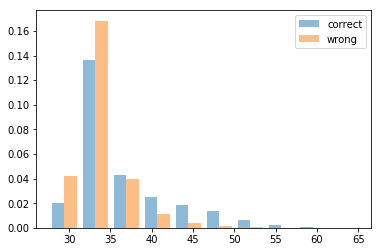

In [18]:
bins = [35,45,55,60,65,70]
plt.hist([correct_scroes,wrong_scores], 10, alpha=0.5, label=['correct','wrong'],density=True)
# plt.hist(wrong_scores, 10, alpha=0.5, label='wrong')
plt.legend(loc='upper right')
# plt.show()

In [19]:
# check unigrams intersection with other relations, both on tokens and entities
# on train as well
for d in result_per_type['NOTA'][0]:
    show_set(d)
    print()
    

head: ian laperrière   ,   tail winger
NOTA position played on team / speciality	 ian laperrière ( born January 19 , 1974 ) is a Canadian former professional ice hockey winger who played 16 seasons in the National Hockey League ( NHL ) . ; 

head: andreas karasiak   ,   tail tenor
voice type	 andreas karasiak ( born 1968 ) is a German classical tenor in opera and concert . 0.86; 34.89
head: eylül   ,   tail turkish
original language of film or TV show	 * eylül is also the name for September in turkish ; this is derived from the Arabic form " ' Aylūl " , used in the Levant ( see Arabic names of calendar months ) .  0.00; 10.86
head: stop trump movement   ,   tail candidacy
main subject	 The controversial candidacy of Donald Trump for the Republican Party nomination caused the creation of the stop trump movement , which sought to stop his nomination or find a candidate to oppose him .  0.00; 21.00
head: priwall peninsula   ,   tail pötenitzer wiek
located in or next to body of water	 Thr

head: kekuʻiapoiwa ii   ,   tail keōua
spouse	 Kamehameha is considered the son of keōua , founder of the House of Keoua , and kekuʻiapoiwa ii .  0.94; 37.54
head: eric norwood   ,   tail defensive end
position played on team / speciality	 eric norwood ( born May 24 , 1988 ) is former American football defensive end .  0.00; 20.68
head: sweden   ,   tail wto
member of	 Leif Pagrotsky has represented sweden in the EU , OECD , wto , UNCTAD , UNESCO and ASEM ( ASEAN - EU ) .  0.00; 17.33
NOTA  0.06; 34.79721450805664


head: phila   ,   tail lamia of athens
NOTA mother	 Demetrius was married five times : He also had an affair with a celebrated courtesan called lamia of athens , by whom he had a daughter called phila . ; 

head: mickey mantle   ,   tail merlyn mantle
spouse	 merlyn mantle ( née Johnson ; January 28 , 1932 – August 10 , 2009 ) was an American author and widow of New York Yankees outfielder mickey mantle . 0.94; 35.47
head: emperor alexander iii   ,   tail michael
child	 He 

head: pertevniyal sultan   ,   tail abdülaziz
NOTA child	 In 1868 , Empress Eugénie visited the Dolmabahçe Palace in Constantinople , the home to Sultana pertevniyal sultan , mother of abdülaziz , 32nd sultan of the Ottoman Empire . ; 

head: ryan mallett   ,   tail quarterback
position played on team / speciality	 On August 31 , 2014 , Keenum was waived by the Texans to clear a roster space for recently acquired quarterback ryan mallett . 0.00; 17.31
head: interstate 435 bridge   ,   tail kansas river
crosses	 The interstate 435 bridge is a girder bridge crossing of the kansas river .  0.00; 15.27
head: augusta fitzclarence   ,   tail dorothy jordan
mother	 Her father was the son of John Kennedy - Erskine ( 1802–1831 ) of Dun and augusta fitzclarence ( 1803–1865 ) , the illegitimate daughter of King William IV and dorothy jordan .  0.02; 35.15
head: monmouthshire   ,   tail river wye
located in or next to body of water	 On 26 June , properties were affected in Tintern on the river wye

follows	 She competed in the Women 's event at the 2012 summer olympics and 2016 summer olympics .  0.00; 25.36
head: frank ernest wallace simpson   ,   tail general
military rank	 general Sir frank ernest wallace simpson , ( 21 March 1899 – 28 July 1986 ) was a senior British Army officer during the 1940s .  0.00; 21.15
head: messier 74   ,   tail pisces
constellation	 SN 2003gd was a type II - P supernova occurring in the spiral galaxy messier 74 in the constellation pisces .  0.84; 34.69
head: king james ii   ,   tail queen mary ii
child	 Lord Clarendon 's daughter Lady Anne Hyde married the future king james ii and was the mother of queen mary ii and Queen Anne .  0.00; 14.85
NOTA  0.13; 32.83047103881836


head: andrew ii of hungary   ,   tail stephen the posthumous
NOTA child	 His father , stephen the posthumous , was the posthumous son of andrew ii of hungary although Stephen 's brothers considered him a bastard . ; 

head: seventy-first   ,   tail seventieth
follows	 Irwin was 

head: adhil   ,   tail andromeda
constellation	 The name adhil has been applied to a number of stars , especially in the constellation andromeda .  0.00; 14.17
NOTA  0.00; 30.177148818969727


head: enrique tucuna   ,   tail basketball
NOTA sport	 enrique tucuna ( born 6 August 1968 ) is an Uruguayan former basketball player . ; 

head: my name is khan   ,   tail autistic
main subject	 India " ( 2007 ) , and an autistic man in the drama " my name is khan " ( 2010 ) . 0.00; 20.72
head: vernon sollas   ,   tail featherweight
competition class	 vernon sollas ( born 14 August 1954 ) is a Scottish former boxer who was British featherweight champion between 1975 and 1977 .  0.46; 34.35
head: nancy pelosi   ,   tail christine pelosi
child	 The group is named for its first two members , House Speaker Rep. nancy pelosi ( CA ) and her daughter christine pelosi ( CA DNC ) , who announced their intention on March 30 .  0.00; 18.88
head: hd 142 b   ,   tail phoenix
constellation	 hd 142 b is a jovi

head: marian bíreš   ,   tail alpine skier
sport	 marian bíreš ( born 27 July 1964 in Banská Bystrica ) is a retired Slovak alpine skier who competed for Czechoslovakia in the 1992 Winter Olympics . 0.89; 36.29
head: mohamed ould abdel aziz   ,   tail general
military rank	 It was led by general mohamed ould abdel aziz .  0.06; 33.67
head: abigail   ,   tail millard fillmore
spouse	 Prior to becoming President of the United States , millard fillmore lived in East Aurora with his wife abigail from 1826 to 1830 .  0.00; 22.04
head: terminal island   ,   tail pacific ocean
located in or next to body of water	 This species occurs in the pacific ocean off terminal island , California .  0.00; 17.04
head: wally swift   ,   tail welterweight
competition class	 During his boxing career Bryan has managed by former British welterweight champion wally swift .  0.02; 32.33
NOTA  0.03; 32.99150085449219


head: john vi   ,   tail maria i of portugal
NOTA mother	 The Portuguese Prince Regent , the f

head: donna summer   ,   tail brooklyn sudano
child	 He worked in the Off - Broadway play “ Crossing Rockaway Parkway ” in New York City with Jonathan Chase and brooklyn sudano ( daughter of donna summer ) .  0.89; 36.82
head: 1965   ,   tail 1961
follows	 He was re - elected at the next four general elections , in 1954 , 1957 , 1961 and 1965 .  0.00; 18.87
NOTA  0.01; 31.99039649963379


head: naseeruddin shah   ,   tail ratna pathak
NOTA spouse	 Shah is the younger son of actors naseeruddin shah and ratna pathak . ; 

head: pascal mahé   ,   tail handball
sport	 In 2000 , he moved to Germany where he grew up , due to his father pascal mahé , a former handball player , taking up several managerial positions in the country . 0.00; 23.82
head: berengar   ,   tail gisela
mother	 As surety for the accord , Lambert pledged to marry gisela , berengar 's daughter .  0.98; 39.10
head: flåvær lighthouse   ,   tail herøyfjord
located in or next to body of water	 The village of Eggesbønes lies s

head: dave glaser   ,   tail squadron leader
NOTA military rank	 Test flying was conducted by squadron leader dave glaser . ; 

head: eugene lytton scott   ,   tail tennis
sport	 eugene lytton scott ( December 28 , 1937 – March 20 , 2006 ) was an American tennis player , tournament director , author and publisher . 0.00; 27.78
head: owensboro bridge   ,   tail ohio river
crosses	 US 231 was previously carried over the ohio river on the owensboro bridge .  0.00; 15.74
head: omicron herculis   ,   tail hercules
constellation	 omicron herculis , Latinized from o Herculis , is a multiple star system in the constellation hercules .  0.00; 19.64
head: pāhoa   ,   tail island of hawaii
part of	 Lava Tree State Monument is a public park located southeast of pāhoa in the Puna District on the island of hawaii .  0.00; 14.09
head: erolcan çinko   ,   tail shooting guard
position played on team / speciality	 erolcan çinko ( born August 15 , 1990 ) is a Turkish professional basketball player who pl

sport	 jørgen gluver ( born June 15 , 1960 ) is a former Danish handball player who competed in the 1984 Summer Olympics .  0.00; 15.84
NOTA  0.42; 32.372283935546875


head: glenn winslade   ,   tail tenor
NOTA voice type	 " 2014 Telstra Women ’s Business Awards " , press release , 21 November 2013 The board of Harbour City Opera includes Wagnerian tenor glenn winslade and singer and pianist Glenn Amer . ; 

head: death to spies   ,   tail world war ii
main subject	 death to spies : Moment Of Truth ( ) is a third - person stealth action PC game set during world war ii . 0.00; 12.34
head: bill cartwright   ,   tail center
position played on team / speciality	 With the drafting and development of Horace Grant , the Bulls traded Oakley to the New York Knicks for 7'1 " center bill cartwright .  0.69; 36.14
head: javed akhtar   ,   tail farhan akhtar
child	 The remake series was created by javed akhtar and his son farhan akhtar , with Shah Rukh Khan starring in the titular role .  0.00; 14

NOTA position played on team / speciality	 Due to the performance of rookie cornerback trevard lindley in the first three preseason games , Harris was switched back to free safety . ; 

head: alexandru agache   ,   tail baritone
voice type	 alexandru agache ( born 16 August 1955 ) is a Romanian operatic baritone who has had an active international career since 1979 . 0.63; 34.06
head: this law of ours and other essays   ,   tail islamic law
main subject	 " This Law of Ours " is a section of the book this law of ours and other essays which contains Asad 's thesis on islamic law .  0.00; 17.40
head: george iv of the united kingdom   ,   tail caroline of brunswick
spouse	 In 1814 , William became briefly engaged with Princess Charlotte of Wales , only daughter of the Prince Regent , later george iv of the united kingdom and his estranged wife caroline of brunswick .  0.00; 20.79
head: cromwell mortimer   ,   tail royal society
member of	 Mortimer was the only son of cromwell mortimer secr

head: expedition 40   ,   tail expedition 39
follows	 A portion of the expedition 39 crew transferred to expedition 40 while the remainder of the crew launched on May 28 , 2014 from Baikonur Cosmodrome in Kazakhstan .  0.00; 16.41
head: julie fuchs   ,   tail soprano
voice type	 julie fuchs is a French soprano .  0.00; 13.53
head: elisabeth of austria   ,   tail elisabeth of bohemia
mother	 In 1454 , he married elisabeth of austria , daughter of the late King of the Romans Albert II of Habsburg by his late wife elisabeth of bohemia .  0.99; 35.12
NOTA  0.01; 30.04326820373535


head: constance   ,   tail alice
NOTA mother	 In the winter of 1135–36 , Ralph supported the regency of constance 's mother , alice . ; 

head: kusaie island   ,   tail caroline islands
part of	 " Steele " sailed on 5 June for kusaie island in the eastern caroline islands to observe enemy activity and possibly to intercept a Japanese submarine believed to be due there on the 6th . 0.00; 13.30
head: paleoproteroz

mother	 In order to create the Nixon scene , the production crew used a real clip of Nixon , his wife , and daughter .  0.84; 34.57
NOTA  0.13; 32.726905822753906


head: v404 cygni   ,   tail cygnus
NOTA constellation	 v404 cygni is a microquasar and a binary system in the constellation of cygnus . ; 

head: barlavento   ,   tail atlantic ocean
located in or next to body of water	 Ilhéu Branco is an uninhabited 300 ha islet in the barlavento group of the Cape Verde archipelago off the coast of north - west Africa in the atlantic ocean . 0.73; 32.95
head: imaginary friends   ,   tail lillian hellman
main subject	 Her feud with fellow writer lillian hellman formed the basis for the play " imaginary friends " by Nora Ephron .  0.00; 17.76
head: stand watie   ,   tail brigadier general
military rank	 The last significant Confederate active force to surrender was the Confederate allied Cherokee brigadier general stand watie and his Indian soldiers on June 23 .  0.00; 20.42
head: 1984 winte

In [20]:
def show_statson_all_relation(correct = 0):
    pred_acc = []
    scores_result = []
    std_result = [] 
    for k,v in result_per_type.items():
        scores_category = np.array(list(map(lambda x: x['scores'][int(x['prediction'])],v[correct])))
        pred_acc.append(len(v[1])/(len(v[0])+len(v[1]))*100)
        scores_result.append(scores_category.mean())
        std_result.append(scores_category.std())
        print(f"{k}:\t {scores_category.mean():.2f} +- {scores_category.std():.2f} ; {len(v[1])/(len(v[0])+len(v[1]))*100:.2f}%")
    #     print( k ,scores_category.mean(), "+-",scores_category.std(), " Acc is:", len(v[1])/(len(v[0])+len(v[1])))
    pred_acc = np.array(pred_acc)
    scores_result = np.array(scores_result)
    std_result = np.array(std_result)
#     X = np.stack((pred_acc,scores_result),axis=0)
#     print(np.cov(X))
#     print(np.corrcoef(np.stack((pred_acc,scores_result),axis=0)))
    return pred_acc,scores_result,std_result

In [21]:
pred_acc,scores_result_correct,std_result_correct = show_statson_all_relation(1)

NOTA:	 32.33 +- 1.11 ; 85.14%
child:	 46.11 +- 5.48 ; 97.46%
follows:	 47.88 +- 7.17 ; 84.75%
main subject:	 35.28 +- 3.09 ; 34.04%
military rank:	 35.66 +- 1.92 ; 85.80%
spouse:	 42.16 +- 5.65 ; 50.31%
constellation:	 38.52 +- 1.87 ; 98.42%
position played on team / speciality:	 40.96 +- 2.39 ; 99.38%
original language of film or TV show:	 45.83 +- 3.62 ; 97.30%
part of:	 35.52 +- 3.49 ; 14.68%
mother:	 42.20 +- 3.45 ; 91.61%
crosses:	 35.86 +- 1.16 ; 92.58%
member of:	 36.15 +- 2.77 ; 28.81%
voice type:	 46.77 +- 4.35 ; 99.68%
located in or next to body of water:	 35.79 +- 1.96 ; 59.69%
competition class:	 37.18 +- 1.57 ; 96.71%
sport:	 37.20 +- 3.07 ; 62.84%


In [22]:
from scipy.stats import pearsonr


In [23]:
pearsonr(pred_acc,scores_result_correct)


(0.4463815700494432, 0.0724742821560534)

In [24]:
pred_acc,scores_result_wrong,std_result_wrong = show_statson_all_relation(0)

NOTA:	 35.37 +- 3.12 ; 85.14%
child:	 34.87 +- 4.70 ; 97.46%
follows:	 32.46 +- 2.19 ; 84.75%
main subject:	 31.70 +- 1.64 ; 34.04%
military rank:	 32.19 +- 0.60 ; 85.80%
spouse:	 34.14 +- 3.45 ; 50.31%
constellation:	 31.79 +- 0.35 ; 98.42%
position played on team / speciality:	 36.44 +- 0.06 ; 99.38%
original language of film or TV show:	 32.30 +- 0.37 ; 97.30%
part of:	 32.04 +- 1.83 ; 14.68%
mother:	 35.14 +- 3.77 ; 91.61%
crosses:	 34.98 +- 1.77 ; 92.58%
member of:	 31.58 +- 1.09 ; 28.81%
voice type:	 33.12 +- 0.00 ; 99.68%
located in or next to body of water:	 32.61 +- 1.47 ; 59.69%
competition class:	 32.96 +- 0.96 ; 96.71%
sport:	 32.88 +- 1.44 ; 62.84%


In [25]:
pearsonr(pred_acc,scores_result_wrong)

(0.47044494400571296, 0.05667972726285477)

In [26]:
from sklearn.metrics import confusion_matrix
mapping_rel_to_index = {}
for i,r in enumerate(result_per_type.keys()):
    mapping_rel_to_index[r] = i

In [27]:
labels = [x for x in result_per_type.keys()]
cm = confusion_matrix(gold_list, pred_list, labels)
for l in cm:
    print(l, sum(l))
# lcm = [[np.log1p(10*(x/sum(row))) for x in row] for row in cm ]
cm[0] = [x/16 for x in cm[0]]
print()
for l in cm:
    print(l, sum(l))
lcm = [[np.log1p(1*(x)) for x in row] for row in cm ]



[4258   68   14   11   17  150   30   61    5   38   91   80   13   18
  106    6   35] 5001
[  5 307   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0] 315
[ 42   1 250   0   0   0   0   0   0   2   0   0   0   0   0   0   0] 295
[177   0   1  96   0   0   1   0   0   3   0   0   1   0   0   0   3] 282
[ 44   0   0   0 272   0   0   1   0   0   0   0   0   0   0   0   0] 317
[101  27   0   0   0 163   0   0   0   0  33   0   0   0   0   0   0] 324
[  5   0   0   0   0   0 312   0   0   0   0   0   0   0   0   0   0] 317
[  0   0   0   0   0   0   0 322   0   0   0   0   0   1   0   0   1] 324
[  8   0   0   0   0   0   0   0 288   0   0   0   0   0   0   0   0] 296
[246   0   7  10   0   0   4   0   0  48   0   1   9   0   1   0   1] 327
[ 16   1   0   0   0   8   0   0   0   0 273   0   0   0   0   0   0] 298
[  8   0   0   0   0   0   0   0   0   0   0 312   0   0  17   0   0] 337
[212   0   0   1   0   0   0   0   0   0   0   0  87   0   0   1   1] 302
[  1   0   0   0   

[Text(0, 0.5, 'NOTA'),
 Text(0, 1.5, 'child'),
 Text(0, 2.5, 'follows'),
 Text(0, 3.5, 'main sub'),
 Text(0, 4.5, 'military'),
 Text(0, 5.5, 'spouse'),
 Text(0, 6.5, 'constell'),
 Text(0, 7.5, 'position'),
 Text(0, 8.5, 'original'),
 Text(0, 9.5, 'part of'),
 Text(0, 10.5, 'mother'),
 Text(0, 11.5, 'crosses'),
 Text(0, 12.5, 'member o'),
 Text(0, 13.5, 'voice ty'),
 Text(0, 14.5, 'located '),
 Text(0, 15.5, 'competit'),
 Text(0, 16.5, 'sport')]

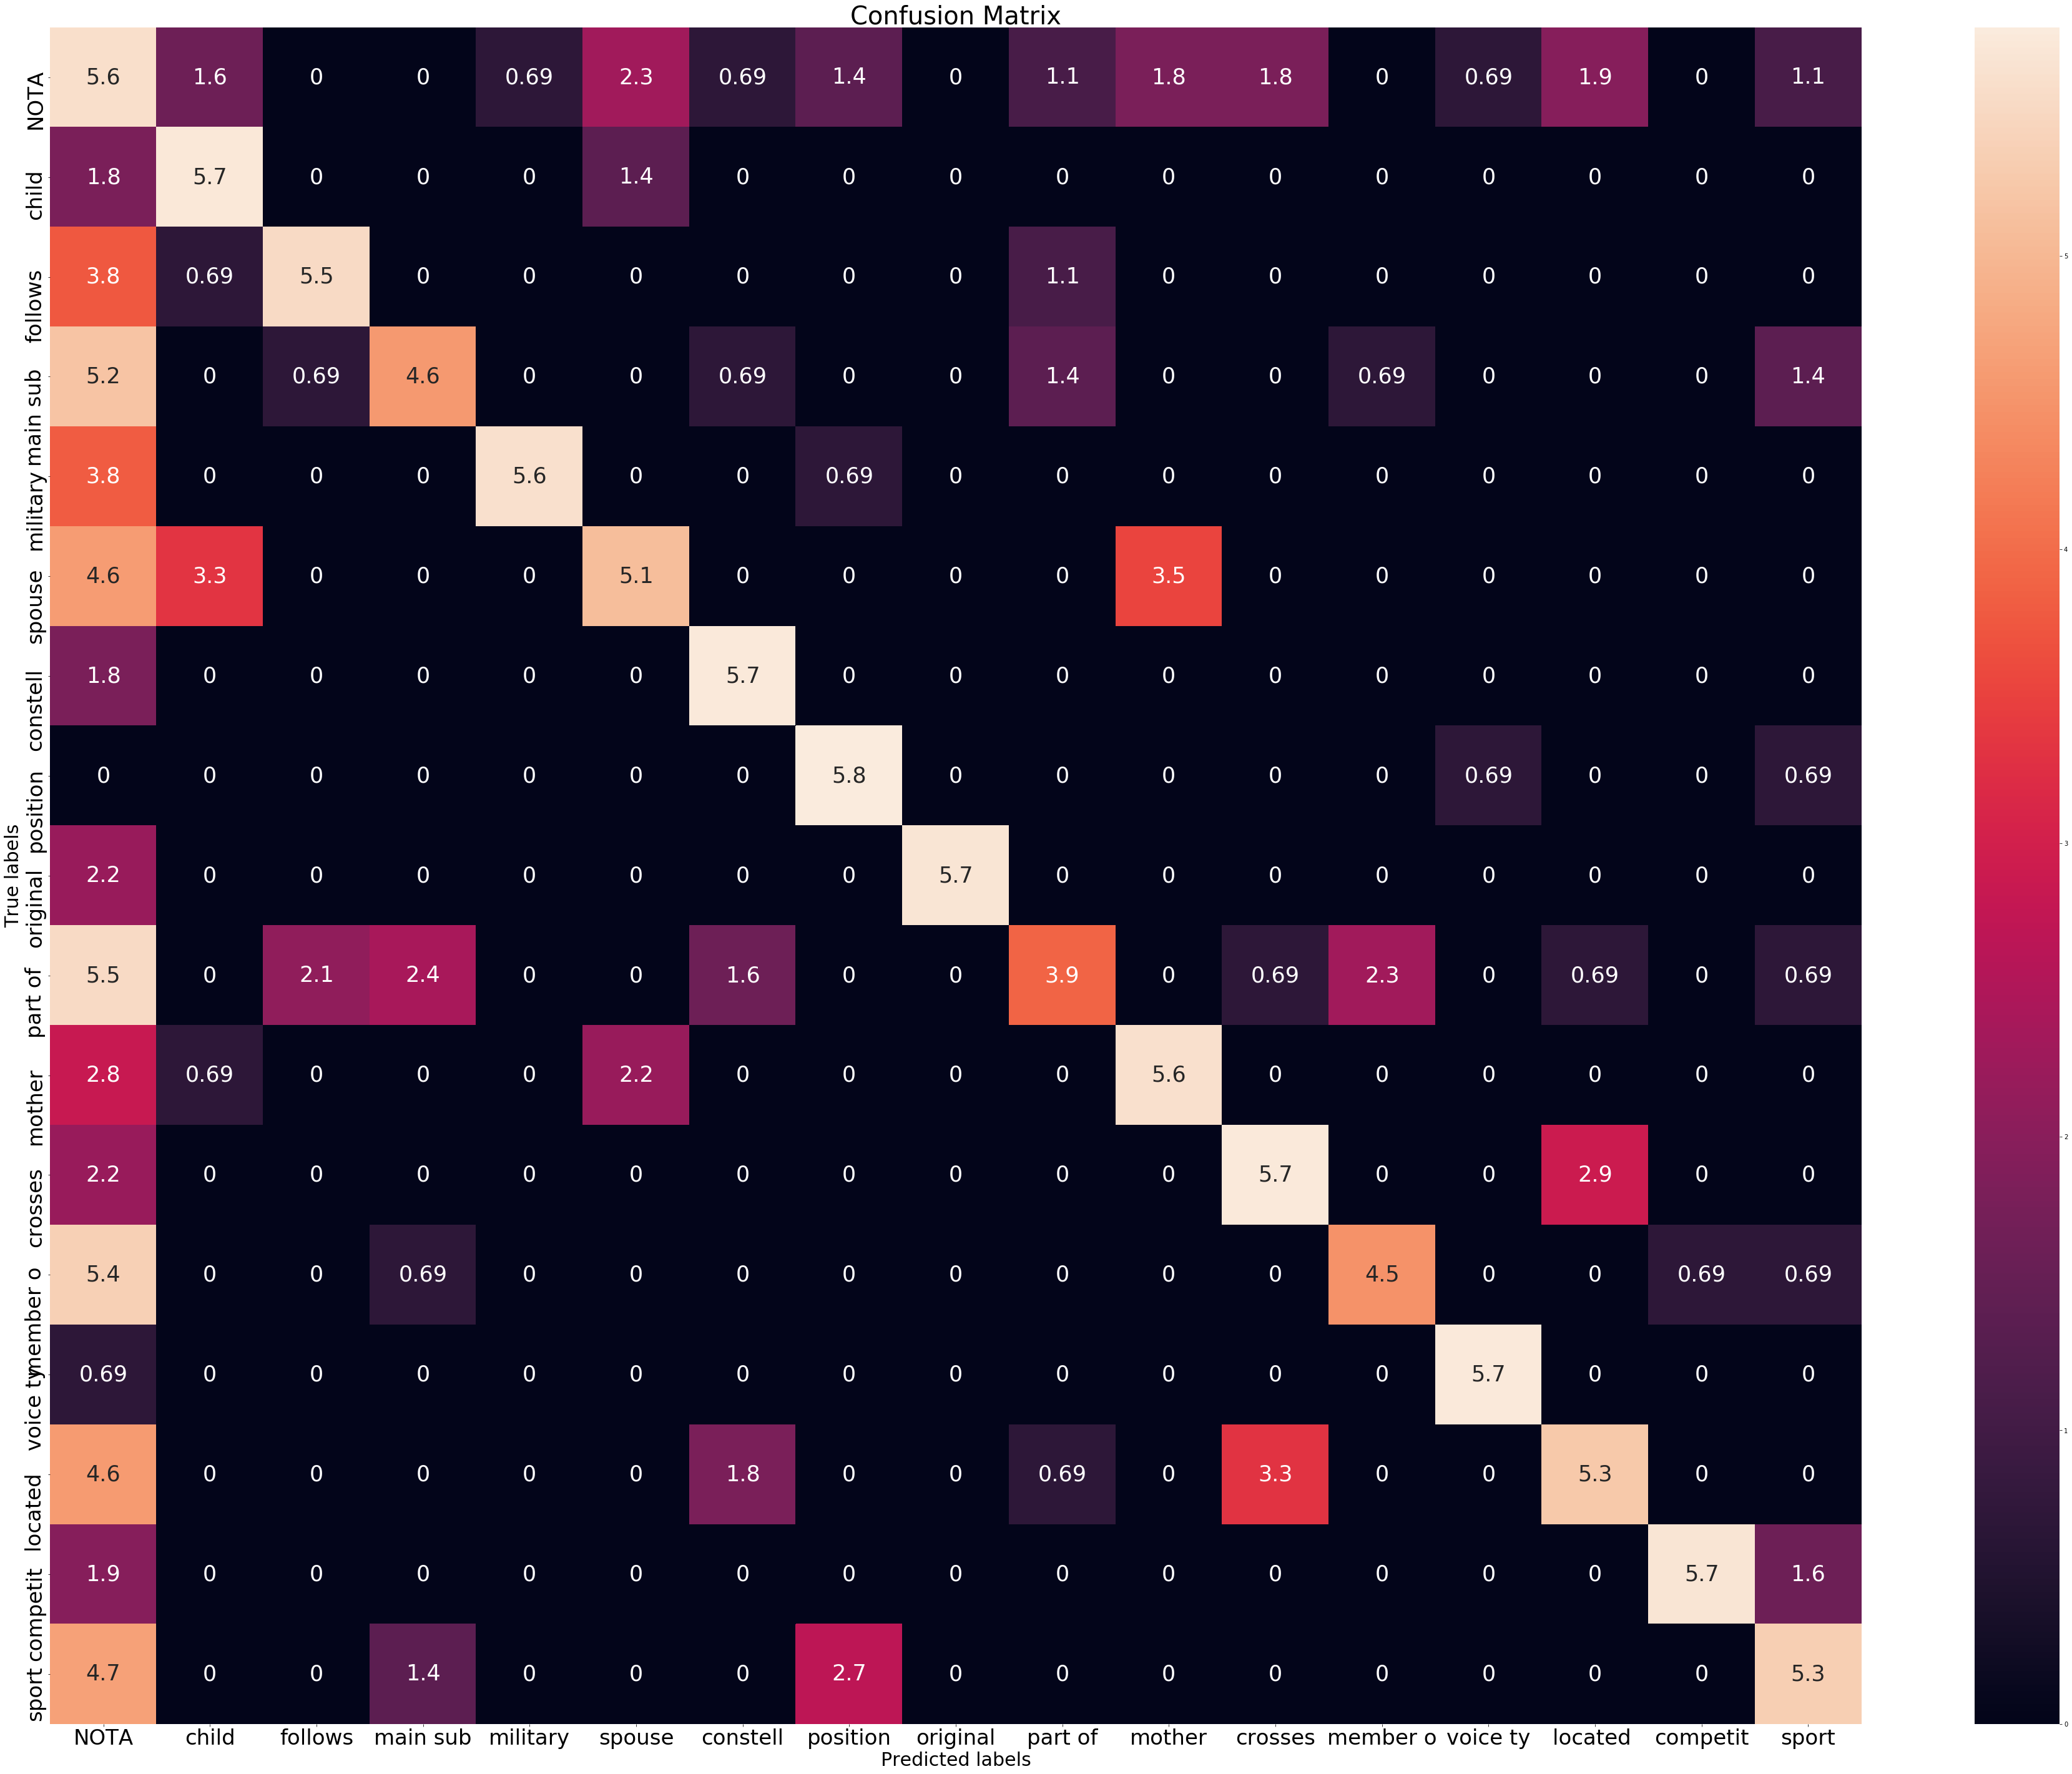

In [28]:
import seaborn as sns

fig = plt.figure(figsize=(65,50))
# ax = fig.add_subplot(111)
ax= plt.subplot()
sns.heatmap(lcm, annot=True, ax = ax,annot_kws={"size": 35}) #annot=True to annotate cells
# sns.set(font_scale=-4.4)
# labels, title and ticks

ax.set_xlabel('Predicted labels',fontsize=30);ax.set_ylabel('True labels',fontsize=30); 
ax.set_title('Confusion Matrix',fontsize=40); 
ax.xaxis.set_ticklabels([x[:8] for x in result_per_type.keys()],fontsize=34)
ax.yaxis.set_ticklabels([x[:8] for x in result_per_type.keys()],fontsize=34)



[Text(0, 0.5, 'NOTA'),
 Text(0, 1.5, 'child'),
 Text(0, 2.5, 'follows'),
 Text(0, 3.5, 'main sub'),
 Text(0, 4.5, 'military'),
 Text(0, 5.5, 'spouse'),
 Text(0, 6.5, 'constell'),
 Text(0, 7.5, 'position'),
 Text(0, 8.5, 'original'),
 Text(0, 9.5, 'part of'),
 Text(0, 10.5, 'mother'),
 Text(0, 11.5, 'crosses'),
 Text(0, 12.5, 'member o'),
 Text(0, 13.5, 'voice ty'),
 Text(0, 14.5, 'located '),
 Text(0, 15.5, 'competit'),
 Text(0, 16.5, 'sport')]

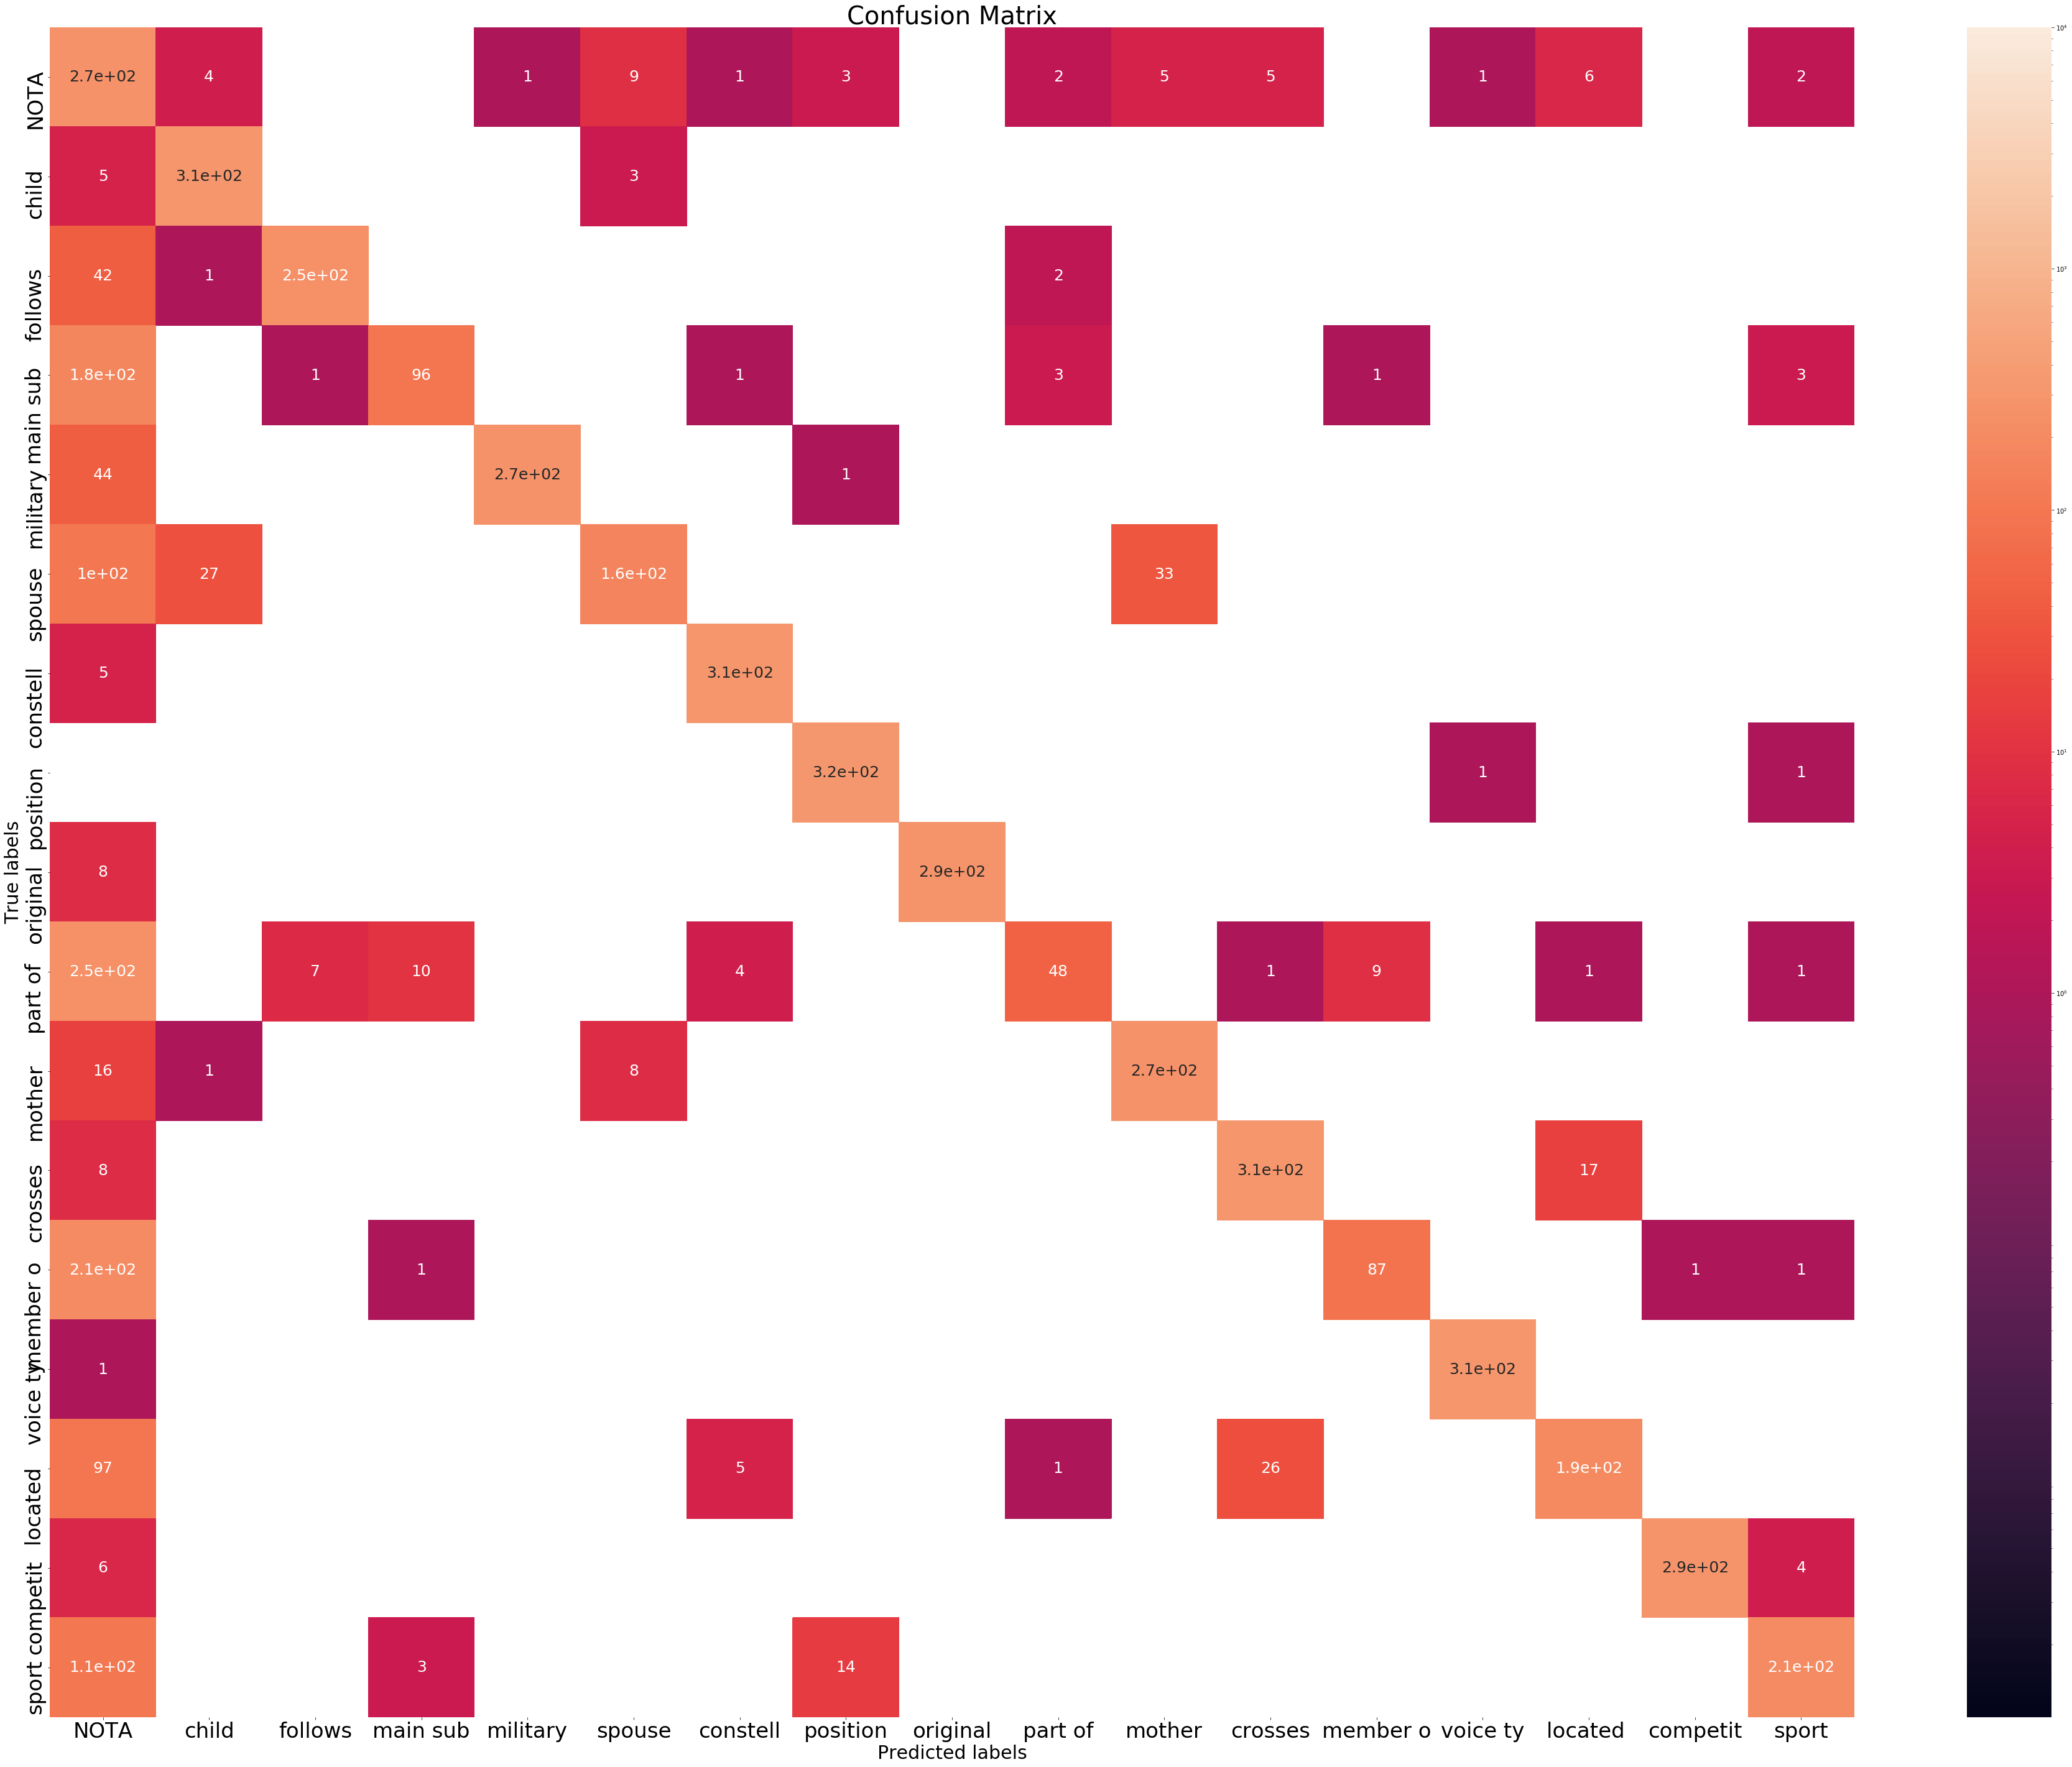

In [29]:
import seaborn as sns
from matplotlib.colors import LogNorm
log_norm = LogNorm(vmin=cm.min().min(), vmax=cm.max().max())

fig = plt.figure(figsize=(65,50))

ax= plt.subplot()

sns.heatmap(cm,norm=log_norm,cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4,1e5]},
            vmin = 0.001, vmax=10000 ,annot=True, ax = ax,annot_kws={"size": 25}) #annot=True to annotate cells
# sns.set(font_scale=-4.4)
# labels, title and ticks

ax.set_xlabel('Predicted labels',fontsize=30);ax.set_ylabel('True labels',fontsize=30); 
ax.set_title('Confusion Matrix',fontsize=40); 
ax.xaxis.set_ticklabels([x[:8] for x in result_per_type.keys()],fontsize=34)
ax.yaxis.set_ticklabels([x[:8] for x in result_per_type.keys()],fontsize=34)



In [30]:
this_dict = {}
for k,v in wrong_prediction_which_rel.items():
    this_dict[k] = [rel_type for rel_type,count in v.most_common()[:5]]
this_dict

{'NOTA': ['spouse',
  'located in or next to body of water',
  'mother',
  'crosses',
  'child'],
 'main subject': ['NOTA', 'sport', 'part of', 'constellation', 'member of'],
 'spouse': ['NOTA', 'mother', 'child'],
 'part of': ['NOTA', 'main subject', 'member of', 'follows', 'constellation'],
 'military rank': ['NOTA', 'position played on team / speciality'],
 'follows': ['NOTA', 'part of', 'child'],
 'sport': ['NOTA', 'position played on team / speciality', 'main subject'],
 'member of': ['NOTA', 'sport', 'main subject', 'competition class'],
 'located in or next to body of water': ['NOTA',
  'crosses',
  'constellation',
  'part of'],
 'mother': ['NOTA', 'spouse', 'child'],
 'position played on team / speciality': ['sport', 'voice type'],
 'child': ['NOTA', 'spouse'],
 'constellation': ['NOTA'],
 'crosses': ['located in or next to body of water', 'NOTA'],
 'competition class': ['NOTA', 'sport'],
 'original language of film or TV show': ['NOTA'],
 'voice type': ['NOTA']}

In [31]:
# check agremment with the model prediction 
# try to come up with b=new baselines to show that data is no good
# Elmo should do worse?
# only entity type is helpful?


In [ ]:
E try to mimic with the same model
no realtion inside TACRED and it may be the target 

In [32]:
from sklearn.metrics import classification_report

In [33]:
labels = [x for x in result_per_type.keys()]
cr = classification_report(gold_list, pred_list, labels)
print(cr)

                                      precision    recall  f1-score   support

                                NOTA       0.80      0.85      0.82      5001
                               child       0.76      0.97      0.85       315
                             follows       0.92      0.85      0.88       295
                        main subject       0.79      0.34      0.48       282
                       military rank       0.94      0.86      0.90       317
                              spouse       0.50      0.50      0.50       324
                       constellation       0.89      0.98      0.93       317
position played on team / speciality       0.81      0.99      0.89       324
original language of film or TV show       0.98      0.97      0.98       296
                             part of       0.52      0.15      0.23       327
                              mother       0.69      0.92      0.79       298
                             crosses       0.74      0.93      